# MAST30034 Project 2 Group 1 Summary Notebook

## 1. Data collection

### Data sources

#### External datasets
- **ABS Census data:** Downloaded from ABS Census DataPacks - General Community Profile. As of 2021.
- **Crime data:**: Downloaded from Crime Statstics Agency - Criminal incident by LGA - Year Ending Mar 2025.
- **Population data:** Downloaded from Department of Transport and Planning. VIF2023 Victoria Demographic Projections to 2051
- **Public transport data:** Downloaded from PTV General Transit Feed Specification (GTFS) Data. As of September 2025.
- **School data:** Dwonloaded from Department of Education. School Locations 2024.

#### Given datasets
- **Rental property listings:** Scraped from domain.com.au. As of September 2025.
- **Moving annual median rent by suburb and town:** Victoria Government Families, Fairness and Housings Rental report. As of March quarter 2025.

**Assumptions and limitations:**

The rental dataset reflects only observed/scraped listings and may not necessarily be representative of all rental properties available within Victoria.

Additionally, using several external datasets (resulting in 57 total features) may introduce potential multicollinearity between features (e.g. number of schools vs suburb population). Thus, the model may capture correlations rather than causal effects. However, we aim to address this through feature selection and feature importance.

Finally, the external datasets span different time periods—some are current (e.g., crime and transport data), while others, such as the ABS Census (last updated in 2021), are less recent. This temporal mismatch may introduce inconsistencies, as demographic or social trends could have shifted in the intervening years. Thus, we assume that the characteristics captured in older datasets remain reasonably stable over time, and any changes since collection are gradual enough not to invalidate their use in modelling current rental prices.

## 2. Dataset building

The 5 external datasets were processed and cleaned to be merged with the rental property listings dataset.

This means that for each rental listing, there will be rental specific attributes (e.g. number of bedrooms, number of schools within 2km), as well as suburb level attributes (e.g. suburb population, suburb crime index).

This gives us 57 initial attributes/features, which need to be further cleaned, processed, filtered and selected to analyse rental prices.

In [2]:
import pandas as pd
merged_dataset = pd.read_csv("../data/processed/real_estate/vic_rentals_all_enriched.csv")
merged_dataset.columns

Index(['listing_id', 'suburb', 'postcode', 'weekly_rent', 'bond',
       'available_date', 'date_listed', 'days_listed', 'bedrooms', 'bathrooms',
       'carspaces', 'property_type', 'address', 'lat', 'lon', 'photo_count',
       'video_count', 'floorplans_count', 'virtual_tour', 'primary_type',
       'secondary_type', 'agency', 'agent_names', 'land_area',
       'num_metro_bus_stops', 'num_metro_tram_stops', 'num_metro_train_stops',
       'num_regional_bus_stops', 'num_regional_train_stops', 'num_schools_2km',
       'Median_age_persons', 'Median_mortgage_repay_monthly',
       'Median_tot_prsnl_inc_weekly', 'Median_rent_weekly',
       'Median_tot_fam_inc_weekly', 'Average_num_psns_per_bedroom',
       'Median_tot_hhd_inc_weekly', 'Average_household_size',
       'Owner occupied (%)', 'Mortgage (%)', 'Total rented (%)',
       'Other tenure (%)', 'Unemployment', 'post_gradutae (%)',
       'Graduate_diploma_certificate(%)', 'Bachelor (%)',
       'Advanced_&_Diploma (%)', 'Certific

## 3. Feature Engineering

### Handling missing values

With the initial merged dataset, need to deal with any possible nan values per feature. This follows a 2 step process:

**1. Mean imputation:** We create a lookup dictionary that is grouped by the property's suburb, property_type, bedrooms, and bathrooms and impute the feature's missing value according to the mean-aggregated dictionary value. Next, we create a relaxed version of this lookup dictionary on 'property_type', 'bedrooms' and use a similar pattern to impute more nans. This is done for the "weekly_rent" and "carspaces" features, which have the among the highest missing values. 

**2. Listwise deletion:** After imputing nans, there is significantly less remaining missing values so just drop them.

Note: land_area was simply dropped and remove despite being a potential useful feature as it had too many missing values i.e 12329/12331

**Assumptions and limitations**
- Assumes features are missing at random and not systematically biased
- Mean imputation may be too simple a method for imputation so may ignore natural variance in features. Though this is aimed to be addressed through the use of lookup dictionaries.

In [2]:
def find_nans(data):
    missing_list = [(col, data[col].isnull().sum()) for col in data.columns]
    non_nans = [(col, cnt) for col, cnt in missing_list if cnt != 0]
    return sorted(non_nans, key=lambda x: x[1], reverse=True)  # sort by column name

### Outlier detection

These numerical features were considered to determine outliers: ['weekly_rent', 'bedrooms', 'bathrooms', 'carspaces', 'num_metro_bus_stops', 'num_metro_tram_stops', 'num_schools_2km', 'incidents_recorded']

We assume that extreme values are unrepresentative, which should be a valid assumption as there are only 27 rental properties above $3000, which should have little impact on model performance.

We used $3000 as the as upper limit for the rental prices of houses in the Vic-Gov website is $2885. (https://www.housing.vic.gov.au/what-does-rent-cost-victoria)

In [ ]:
#Find how many 0 weekly_rent values there are
zero_rent_count = (data["weekly_rent"] == 0).sum()
print("Zero rent count:", zero_rent_count)

#Find how many high outlier weekly_rent values there are i.e above 3000
highoutlier_rent_count = (data["weekly_rent"] >= 3000).sum()
print("High outlier rent count:", highoutlier_rent_count)

#Find how many data points with 50 or more bedrooms
high_bedroom_count = (data["bedrooms"] >= 50).sum()
print("High bedroom count:", high_bedroom_count)

Zero rent count: 16
High outlier rent count: 27
High bedroom count: 1


Surprisingly, not many outliers were detected. Removing these outliers gives the following distribution for the numerical values:

In [ ]:
#Remove outliers rows
data = data[(data["weekly_rent"] > 0) & (data["weekly_rent"] <= 3000) & (data["bedrooms"] < 50)]
#Looking at numerical variables
data[['weekly_rent', 'bedrooms', 'bathrooms', 'carspaces', 'num_metro_bus_stops', 'num_metro_tram_stops', 'num_schools_2km', 'incidents_recorded']].describe()

,weekly_rent,bedrooms,bathrooms,carspaces,num_metro_bus_stops,num_metro_tram_stops,num_schools_2km,incidents_recorded
count,12018.000000,12018.000000,12018.000000,12018.000000,12018.000000,12018.000000,12018.000000,12018.000000
mean,621.903977,2.720835,1.587203,1.626061,61.837910,20.948910,8.061075,13259.928384
std,249.176926,1.081993,0.629443,0.946937,43.221829,35.017988,4.798088,5828.544925
min,33.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,77.000000
25%,490.000000,2.000000,1.000000,1.000000,22.000000,0.000000,4.000000,9525.000000
50%,560.000000,3.000000,2.000000,1.000000,66.000000,0.000000,8.000000,13140.500000
75%,683.000000,4.000000,2.000000,2.000000,96.000000,35.000000,12.000000,17495.333333
max,3000.000000,11.000000,12.000000,22.000000,183.000000,127.000000,23.000000,34620.000000


Finally, after encoding categorical variables (extracting time features from 'available_date'), our dataset is finally cleaned and ready to be analysed to determine important features for predicting rental prices.

## 4. Modelling Feature Importance

Models: Random Forest Regressor and GX boost were selected with their ability to capture complex relationships in data and a useful feature importance function to help understand which features are were most important in model predictions. 

### Feature Engeering And Encoding

Time data was feature engineered to hour, day and month; and then encoded using cyclic encoding to help model capture potential seasonal change in rent prices.

Frequency encoding was used for non-numerical features i.e postcode, property_type and agency. 

In [ ]:
#Feature Engineering time data
data['available_date'] = pd.to_datetime(data['available_date'], errors='coerce')
data['available_day'] = data['available_date'].dt.day
data['available_month'] = data['available_date'].dt.month   
data['available_year'] = data['available_date'].dt.year
data = data.drop(columns=['available_date'])

In [ ]:
# Encode month cyclically 
data['month_sin'] = np.sin(data['available_month'] / 12 * 2 * np.pi)
data['month_cos'] = np.cos(data['available_month'] / 12 * 2 * np.pi)
data = data.drop(columns=['available_month'])

#Encode day cyclically
data['day_sin'] = np.sin(data['available_day'] / 31 * 2 * np.pi)
data['day_cos'] = np.cos(data['available_day'] / 31 * 2 * np.pi)
data = data.drop(columns=['available_day'])

#Frequency encoding for Non-numericeal columns
post_freq = data['postcode'].value_counts(normalize=True)
data['postcode'] = data['postcode'].map(post_freq)
property_freq = data['property_type'].value_counts(normalize=True)
data['property_type'] = data['property_type'].map(property_freq)
agency_freq = data['agency'].value_counts(normalize=True)
data['agency'] = data['agency'].map(agency_freq)

#### Limitations and Assumptions

We assume that postcode, propety_type and agency have certain catergories(e.g a common postcode, popular property type,etc.) that can influence weekly rent prices. 

Cycle encodinng treats and months and day pattern as if patterns always repeat identically, training only on 2025 might cause bias in the predictions of data for a different year. This shouldn't be an issue as this data set will not be used in forcasting.

### Data leakage

Certain features in the data such as 'median_rent_weekly', 'median_morgage_repay_monthly' and 'bond' can cause data leakage and hence removed. (bond was remove earlier in preprocessing)

In [ ]:
#Drop lat and long for modeling
data = data.drop(columns=['lat', 'lon', 'Median_rent_weekly', 'Median_mortgage_repay_monthly'])

All data was rescaled using the Standardize Scalar method

In [ ]:
#Standardize scalar, resacling all data. (can target specific columns if needed)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Findings

Feature Selection was conducted using Mutual Information(MI) as we hav 42 features. 20 Features were selected from the 42.

Results show that models without feature selection performes significantly better with average r^2 of 0.7 and average MAE of 70 compared to mdoels with feature selection with average r^2  0.25 and average MAE of 126.5.

Cause: likely due to MI only capturing univeriate relationships between one variable vs target variable while our data contains strong multivariable interactions; hence MI fails to compare them and discards useful features.

In [ ]:
# Compute MI
mi = mutual_info_regression(X, y, discrete_features="auto", random_state=0)
mi_scores = pd.Series(mi, index=X.columns).sort_values(ascending=False)

k = 20
selected_features = mi_scores.head(k).index.tolist()

X_selection = X[selected_features]
X_selection

Models 
Key features: bathrooms, bedrooms and Bachelor (%) were signficantly more important than every other variable.

In [35]:
rf_feature_importance = pd.read_csv("../data/outputs/rf_importance_features.csv")
rf_feature_importance.head(10)

,feature,importance
0,bathrooms,0.232121
1,Bachelor (%),0.166932
2,bedrooms,0.121920
3,days_listed,0.037450
4,num_metro_bus_stops,0.025811
5,Median_tot_fam_inc_weekly,0.025658
6,Median_tot_prsnl_inc_weekly,0.025487
7,num_metro_tram_stops,0.024612
8,agency,0.021993
9,Graduate_diploma_certificate(%),0.020688


In [36]:
gxboost_feature_importance = pd.read_csv("../data/outputs/gxboost_importance_features.csv")
gxboost_feature_importance.head(10)

,feature,importance
0,bathrooms,0.266131
1,bedrooms,0.210042
2,Bachelor (%),0.143386
3,Median_tot_fam_inc_weekly,0.084951
4,Certificate_level (%),0.031082
5,Median_tot_prsnl_inc_weekly,0.026502
6,Graduate_diploma_certificate(%),0.024573
7,num_metro_tram_stops,0.022660
8,days_listed,0.022043
9,population_est,0.021998


## 5. Liveability & affordability



### Components that go into livability score of a suburb are: 
- number of schools  
- number of train, bus and tram stops 
- crime index as normalised (0-100) score of total offenses recorded within the suburb, where below 20 is considered low crime

To quanitify the livability we assigned weights to the components above, the assumption was that crime is the most important indicator of suburb's quality hence its weight of 0.4. Number of schools is the second most important factor with weight 0.3, then number of public transport stops with overall weight of 0.3. 

### Affordability calculation 

Affordability was quantified as ratio of weekly rent to median weekly household income in a suburb


In [37]:
import pandas as pd 

affordable = pd.read_csv("../data/outputs/top20_affordable.csv")
livable = pd.read_csv("../data/outputs/top20_livable.csv")

rentals = pd.read_csv("../data/processed/real_estate/vic_rentals_all_enriched.csv")

drop = [column for column in rentals.columns if column not in ['suburb', 'postcode']]

sub = rentals.drop(columns=drop)

suburb = sub.drop_duplicates()

most_affordable = affordable.merge(suburb, on='postcode', how='left')

most_livable = livable.merge(suburb, on='postcode', how='left')


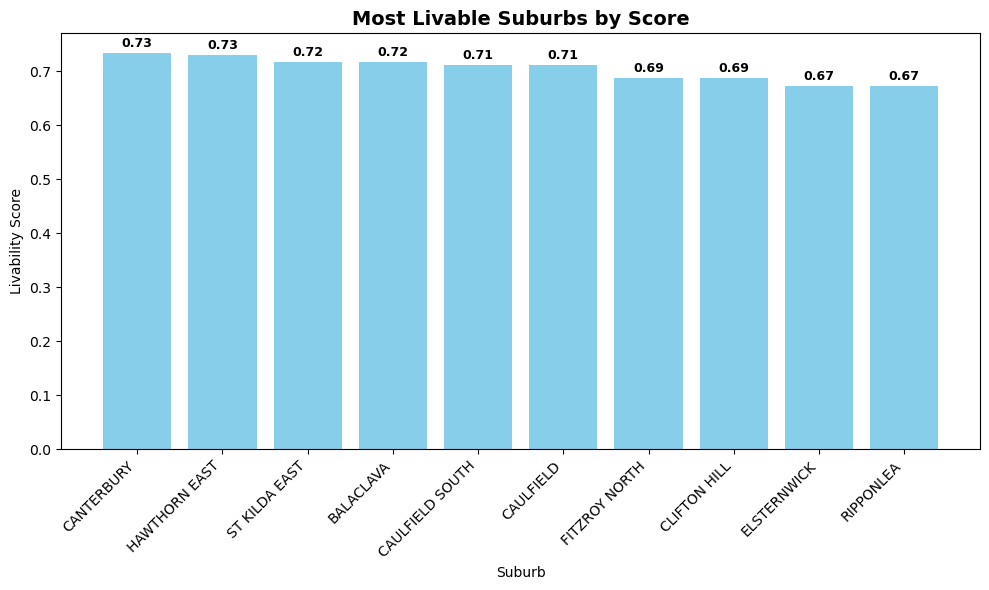

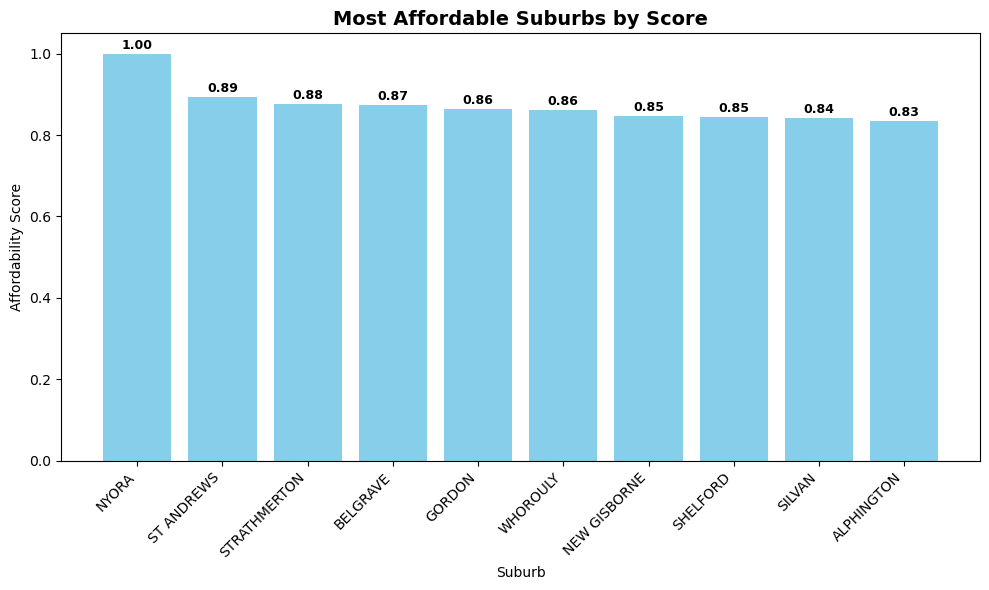

In [22]:
import matplotlib.pyplot as plt

most_livable = most_livable[:10]
plt.figure(figsize=(10,6))
bars = plt.bar(most_livable['suburb'], most_livable['livability_score'], color='skyblue')

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 0.005,
             f"{bar.get_height():.2f}",
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.title("Most Livable Suburbs by Score", fontsize=14, fontweight='bold')

plt.ylabel("Livability Score")
plt.xlabel("Suburb")
# Rotate x labels for readability
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


most_affordable=most_affordable[:10]
plt.figure(figsize=(10,6))
bars = plt.bar(most_affordable['suburb'], most_affordable['affordability_score'], color='skyblue')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 0.005,
             f"{bar.get_height():.2f}",
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.title("Most Affordable Suburbs by Score", fontsize=14, fontweight='bold')
plt.ylabel("Affordability Score")
plt.xlabel("Suburb")
# Rotate x labels for readability
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



## 5. Rent Forecasting

The model that we incorporated was time series with ... 

### Findings 

Our model allowed as to forecast weekly rental price for each quarter of the next 5 years. When we ran the model on validation set with historical data it resulted in accuracy of ... % which is satisfactory. 

### Below is an analysis of our predictions, divided into sections:

1. Average growth of rental prices by suburbs, first on the overall level and then computed for both only houses and only apartments 
2. Return on Investment analysis done by including current property prices for houses and apartments (extracted from the Victorian
goverment website). Question that we're answering here is: 

#### If I buy a property (house/unit) in suburb X how much annual return can I see in the next 5 years?

In [24]:
import pandas as pd 

houses = pd.read_csv("../data/outputs/houses_growth.csv")

units = pd.read_csv("../data/outputs/apartments_growth.csv")

overall = pd.read_csv("../data/outputs/overall_growth.csv")

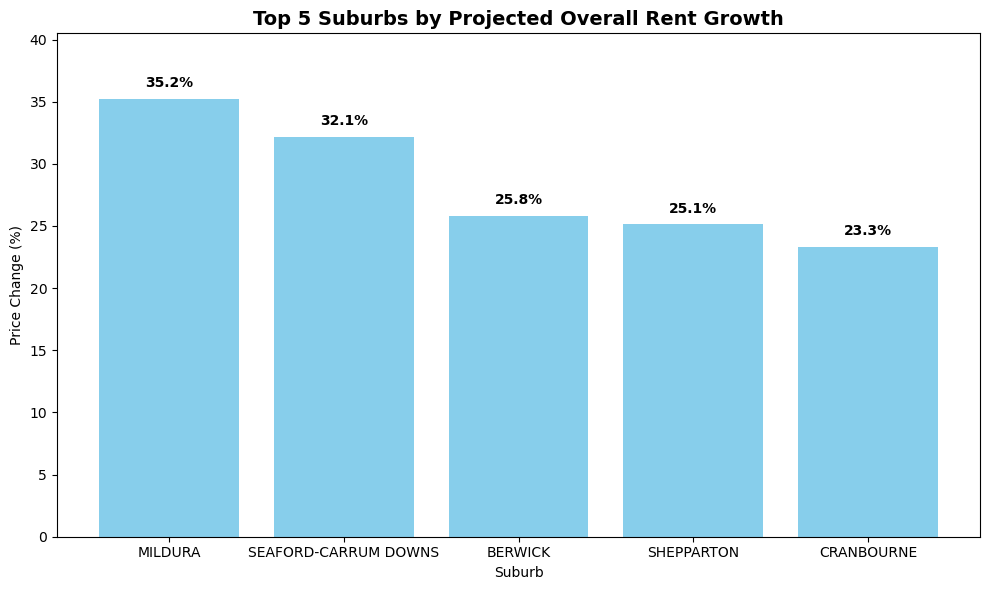

In [40]:
import matplotlib.pyplot as plt

# Sort by growth and select top 5 (just in case your df has more rows)
top5 = overall.sort_values(by="Price_change (%)", ascending=False).head(5)

import matplotlib.pyplot as plt

def plot_top_growth(df, name, n=5):
    """
    Plots a bar chart of the top n suburbs by projected price growth (%).

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns: 'Suburb' and 'Price_change (%)'.
    n : int, optional
        Number of top suburbs to display (default = 5).
    """
    # Sort and select top n
    top = df.sort_values(by="Price_change (%)", ascending=False).head(n)

    # Plot
    plt.figure(figsize=(10,6))
    bars = plt.bar(top["Suburb"], top["Price_change (%)"], color="skyblue")

    # Add labels on bars with a small vertical offset
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, 
                 height + (0.02 * top["Price_change (%)"].max()),  # offset = 2% of max value
                 f"{height:.1f}%", 
                 ha='center', va='bottom', fontsize=10, fontweight="bold")

    # Titles and labels
    plt.title(f"Top {n} Suburbs by Projected {name} Rent Growth", fontsize=14, fontweight="bold")
    plt.ylabel("Price Change (%)")
    plt.xlabel("Suburb")

    # Increase y-axis limit so labels are not cut off
    plt.ylim(0, top["Price_change (%)"].max() * 1.15)

    plt.tight_layout()
    plt.show()


plot_top_growth(top5, 'Overall')

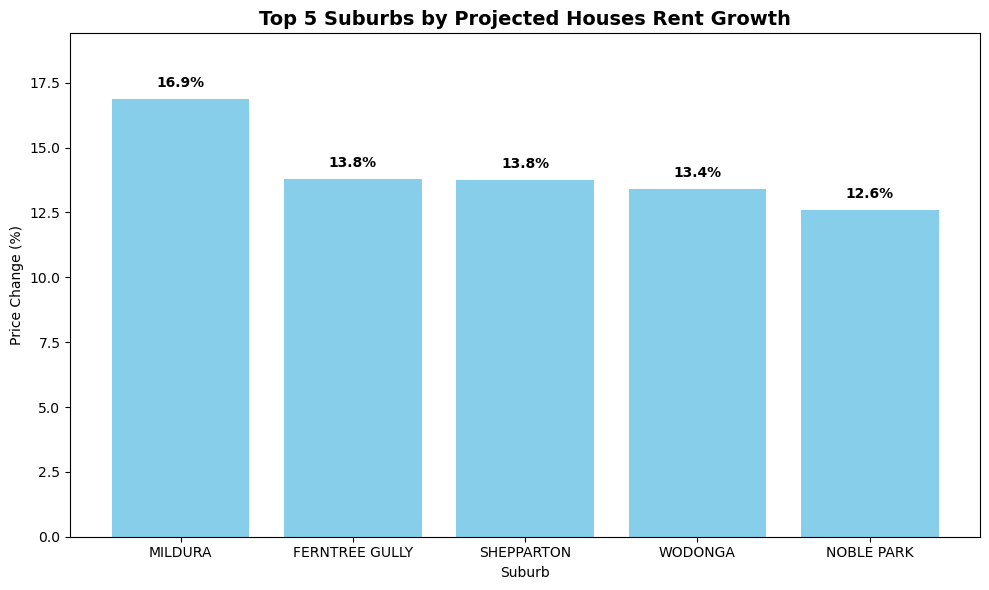

In [29]:
houses = houses.rename(columns={"House_ALL_avg_price_change(%)" : "Price_change (%)"})

top5_houses = houses.sort_values(by="Price_change (%)", ascending=False).head(5)

plot_top_growth(top5_houses, 'Houses')

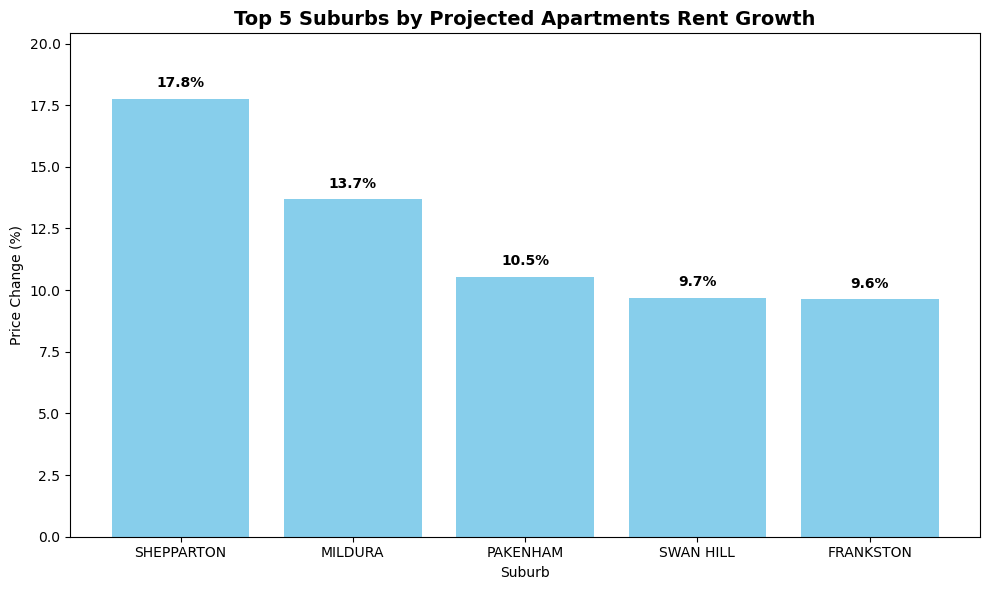

In [30]:
apartments = units.rename(columns={"apartment_ALL_avg_price_change(%)" : "Price_change (%)"})

top5_apartments = apartments.sort_values(by="Price_change (%)", ascending=False).head(5)

plot_top_growth(top5_apartments, 'Apartments')

In [31]:
top5_apartments_ROI = apartments.sort_values(by="apartment_5yr ROI (%)", ascending=False).head(5)

top5_apartments_ROI

,Unnamed: 0,Suburb,apartment_price,Num_sales_units,unit_1bed_Rent_today,unit_1bed_unit_avg,unit_1bed_2025_avg,unit_1bed_2026_avg,unit_1bed_2027_avg,unit_1bed_2028_avg,...,unit_3bed_2027_avg,unit_3bed_2028_avg,unit_3bed_2029_avg,unit_3bed_2030_avg,unit_3bed_avg_future_rent,unit_3bed_Price_change (%),Price_change (%),apartment_ALL_future_rent,apartment_Annual ROI (%),apartment_5yr ROI (%)
0,362,SOUTH YARRA,575000,191,500.103639,500.103639,504.935506,508.428859,517.011144,530.721319,...,1154.552674,1182.333775,1214.629087,1232.219719,1152.753749,7.330790,5.914254,809.520468,0.140786,0.703931
1,129,DOCKLANDS,635000,117,592.114321,592.114321,603.822952,615.135210,620.342931,621.685846,...,1195.629721,1221.301754,1254.069451,1273.104670,1217.689083,2.265161,4.025499,881.751702,0.138859,0.694293
2,248,MALVERN EAST,486000,61,475.050119,475.050119,482.274510,492.351792,505.788169,519.224545,...,836.666131,857.635167,878.604203,891.709851,838.990379,5.554829,5.891352,661.868896,0.136187,0.680935
3,371,ST KILDA,535000,159,458.006045,458.006045,455.721777,448.312082,446.089379,460.801736,...,996.899900,1022.773286,1049.020186,1066.705407,1000.856104,5.159996,4.239949,709.281873,0.132576,0.662880
4,120,DANDENONG,400000,118,365.493382,365.493382,370.621906,378.555850,389.134443,399.713035,...,660.579865,681.870106,701.349461,712.933875,658.257446,8.320272,9.072721,521.268186,0.130317,0.651585


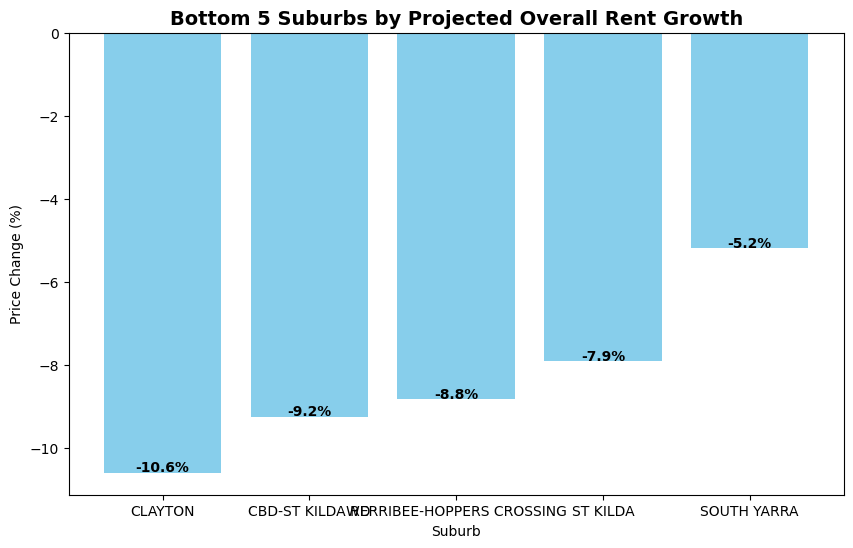

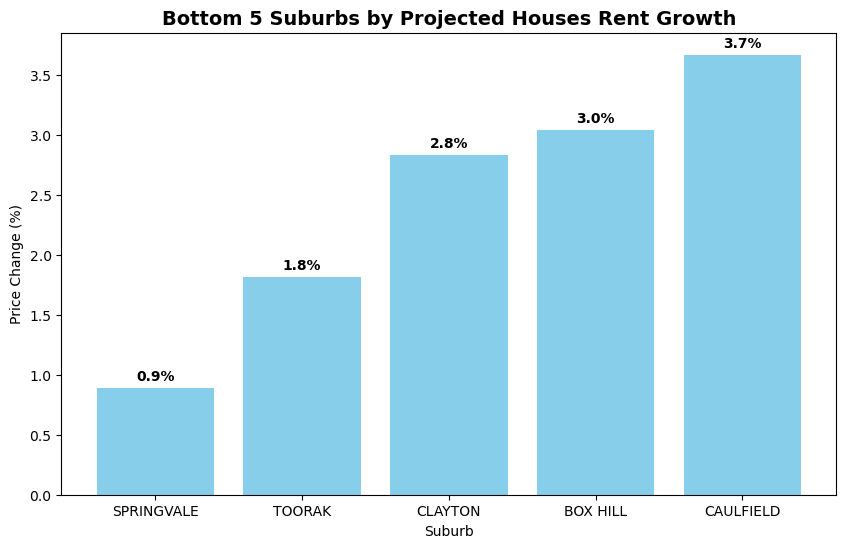

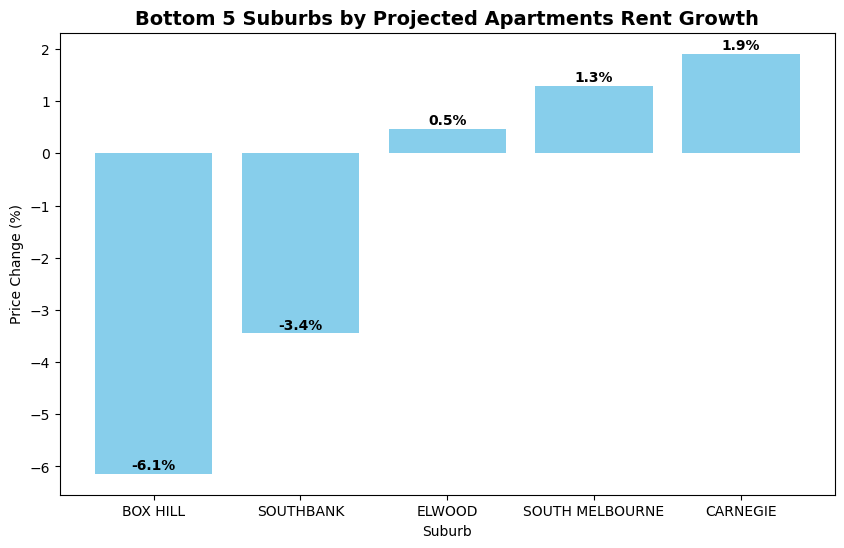

In [34]:
def plot_bottom_growth(df, name, n=5):

    # Sort and select top n
    top = df.sort_values(by="Price_change (%)", ascending=True).head(n)

    # Plot
    plt.figure(figsize=(10,6))
    bars = plt.bar(top["Suburb"], top["Price_change (%)"], color="skyblue")

    # Add labels on bars with a small vertical offset
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, 
                 height + (0.01 * top["Price_change (%)"].max()),  # offset = 2% of max value
                 f"{height:.1f}%", 
                 ha='center', va='bottom', fontsize=10, fontweight="bold")

    # Titles and labels
    plt.title(f"Bottom {n} Suburbs by Projected {name} Rent Growth", fontsize=14, fontweight="bold")
    plt.ylabel("Price Change (%)")
    plt.xlabel("Suburb")

plot_bottom_growth(overall, 'Overall')
plot_bottom_growth(houses, 'Houses')
plot_bottom_growth(apartments, 'Apartments')


## 6. Limitations